<a href="https://colab.research.google.com/github/ThatNinjaGuy/Machine-learning-A-Z-Course/blob/main/stock_market_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data.set_index('Timestamp', inplace=True)
    return data

def resample_data(data):
    data_to_resample = data.drop(columns=['Date'])
    resampled_data = data_to_resample.resample('30T').mean()
    return resampled_data

def plot_resampled_data(resampled_data):
    fig, ax = plt.subplots(figsize=(12, 6))
    resampled_data['Close'].plot(ax=ax, title='Stock Prices (Close) - Resampled to 30-Minute Intervals', ylabel='Price')
    plt.show()

def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def plot_moving_averages(data, ma_windows):
    fig, axes = plt.subplots(len(ma_windows), 1, figsize=(12, 4 * len(ma_windows)), sharex=True)

    if len(ma_windows) == 1:
        axes = [axes]

    for i, window in enumerate(ma_windows):
        ma = calculate_moving_average(data, window)
        data['Close'].plot(ax=axes[i], label='Close Price', color='blue')
        ma.plot(ax=axes[i], label=f'MA{window}', color='orange')
        axes[i].set_title(f'Moving Average (MA{window})')
        axes[i].set_ylabel(f'MA{window}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_macd(macd, signal):
    fig, ax = plt.subplots(figsize=(12, 6))
    macd.plot(ax=ax, label='MACD', color='b')
    signal.plot(ax=ax, label='Signal Line', color='r')
    ax.set_title('MACD')
    ax.legend()
    plt.show()

def plot_rsi(rsi):
    fig, ax = plt.subplots(figsize=(12, 6))
    rsi.plot(ax=ax, label='RSI', color='g')
    ax.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax.set_title('RSI')
    ax.legend()
    plt.show()

def plot_volume(data):
    fig, ax = plt.subplots(figsize=(12, 6))
    data['Volume'].plot(ax=ax, title='Trading Volumes', ylabel='Volume')
    plt.show()

def add_computed_values(data, ma_windows):
    # Calculate Moving Averages
    for window in ma_windows:
        data[f'MA{window}'] = calculate_moving_average(data, window)

    # Calculate MACD and Signal Line
    macd, signal = calculate_macd(data)
    data['MACD'] = macd
    data['Signal'] = signal

    # Calculate RSI
    rsi = calculate_rsi(data)
    data['RSI'] = rsi

    return data


In [2]:
pip install firebase-admin

In [31]:
import firebase_admin
from firebase_admin import credentials, db

# Function to initialize Firebase app
def initialize_firebase():
    if not firebase_admin._apps:
        cred = credentials.Certificate('/content/stockmarket-b9c19-firebase-adminsdk-uqexr-f4be4c7249.json')
        firebase_admin.initialize_app(cred, {
            'databaseURL': 'https://stockmarket-b9c19-default-rtdb.firebaseio.com/'
        })

# Function to upload data to firebase in chunks
def upload_data_to_firebase(data, stock_name):
    # Initialize Firebase app if not already initialized
    initialize_firebase()

    # Reference to the Firebase database
    ref = db.reference('stocks/' + stock_name)

    # Reset the index and convert timestamps to strings
    data.reset_index(inplace=True)  # Reset the index to ensure it's unique
    data['Timestamp'] = data['Timestamp'].astype(str)  # Convert Timestamps to strings

    # Replace out-of-range float values with None
    data = data.replace({float('inf'): None, float('-inf'): None, float('nan'): None})

    # Convert the dataframe to a dictionary
    data_dict = df_to_dict(data)

    # Upload data in chunks
    batch_size = 500  # Adjust batch size as needed
    # for i in range(0, len(data_dict), batch_size):
    #     chunk = dict(list(data_dict.items())[i:i + batch_size])
    #     ref.update(chunk)

    print("Data uploaded to Firebase successfully.")

# Function to convert dataframe to dictionary
def df_to_dict(df):
    return df.to_dict(orient='index')


In [34]:
import numpy as np

def moving_average_signal(data, window, lookback_period=1):
    signal_col = f'Signal_MA{window}'
    position_col = f'Position_MA{window}'

    data[signal_col] = 'Uninvested'
    valid_ma = data[f'MA{window}'].notna()
    buy_condition = (data['Close'].shift(lookback_period) > data[f'MA{window}']) & valid_ma
    sell_condition = (data['Close'].shift(lookback_period) < data[f'MA{window}']) & valid_ma
    data.loc[buy_condition, signal_col] = 'Buy'
    data.loc[sell_condition, signal_col] = 'Sell'
    data[position_col] = data[signal_col].apply(lambda x: 1 if x == 'Buy' else -1 if x == 'Sell' else 0)
    data[position_col] = data[position_col].diff()

    return data

def rsi_strategy(data, lower_threshold=30, upper_threshold=70):
    data['Signal_RSI'] = 'Uninvested'
    valid_rsi = data['RSI'].notna()
    buy_condition = (data['RSI'] < lower_threshold) & valid_rsi
    sell_condition = (data['RSI'] > upper_threshold) & valid_rsi
    data.loc[buy_condition, 'Signal_RSI'] = 'Buy'
    data.loc[sell_condition, 'Signal_RSI'] = 'Sell'
    data['Position_RSI'] = data['Signal_RSI'].apply(lambda x: 1 if x == 'Buy' else -1 if x == 'Sell' else 0)
    data['Position_RSI'] = data['Position_RSI'].diff()

    return data


In [32]:
def backtest_strategy(data, position_col, portfolio_col):
    initial_cash = 10000
    cash = initial_cash
    holdings = 0
    portfolio_value = []

    for i in range(len(data)):
        if data[position_col].iloc[i] == 1:  # Buy signal
            if cash > 0:
                holdings = cash / data['Close'].iloc[i]
                cash = 0
        elif data[position_col].iloc[i] == -1:  # Sell signal
            if holdings > 0:
                cash = holdings * data['Close'].iloc[i]
                holdings = 0
        portfolio_value.append(cash + holdings * data['Close'].iloc[i])

    data[portfolio_col] = portfolio_value
    total_gain = portfolio_value[-1] - initial_cash
    return data, total_gain


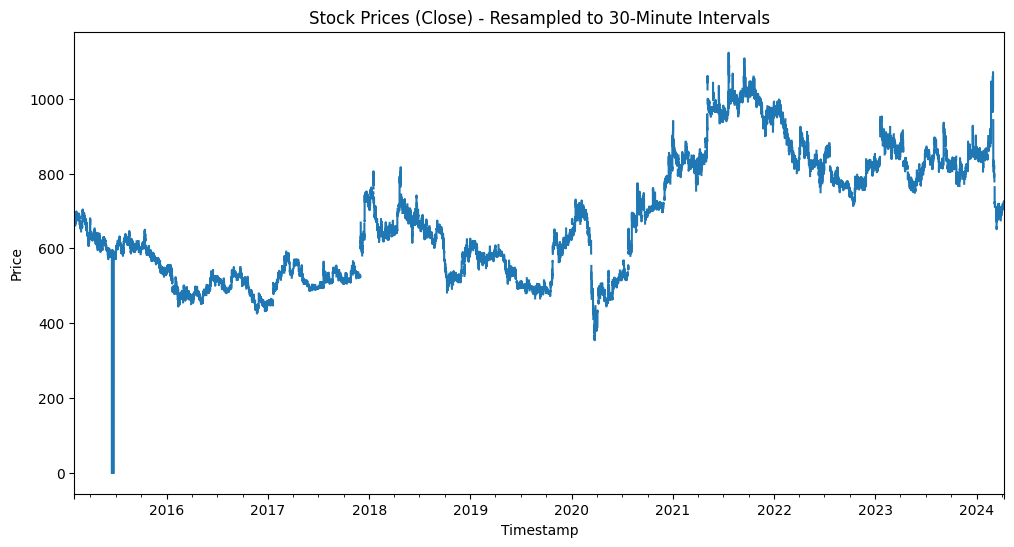

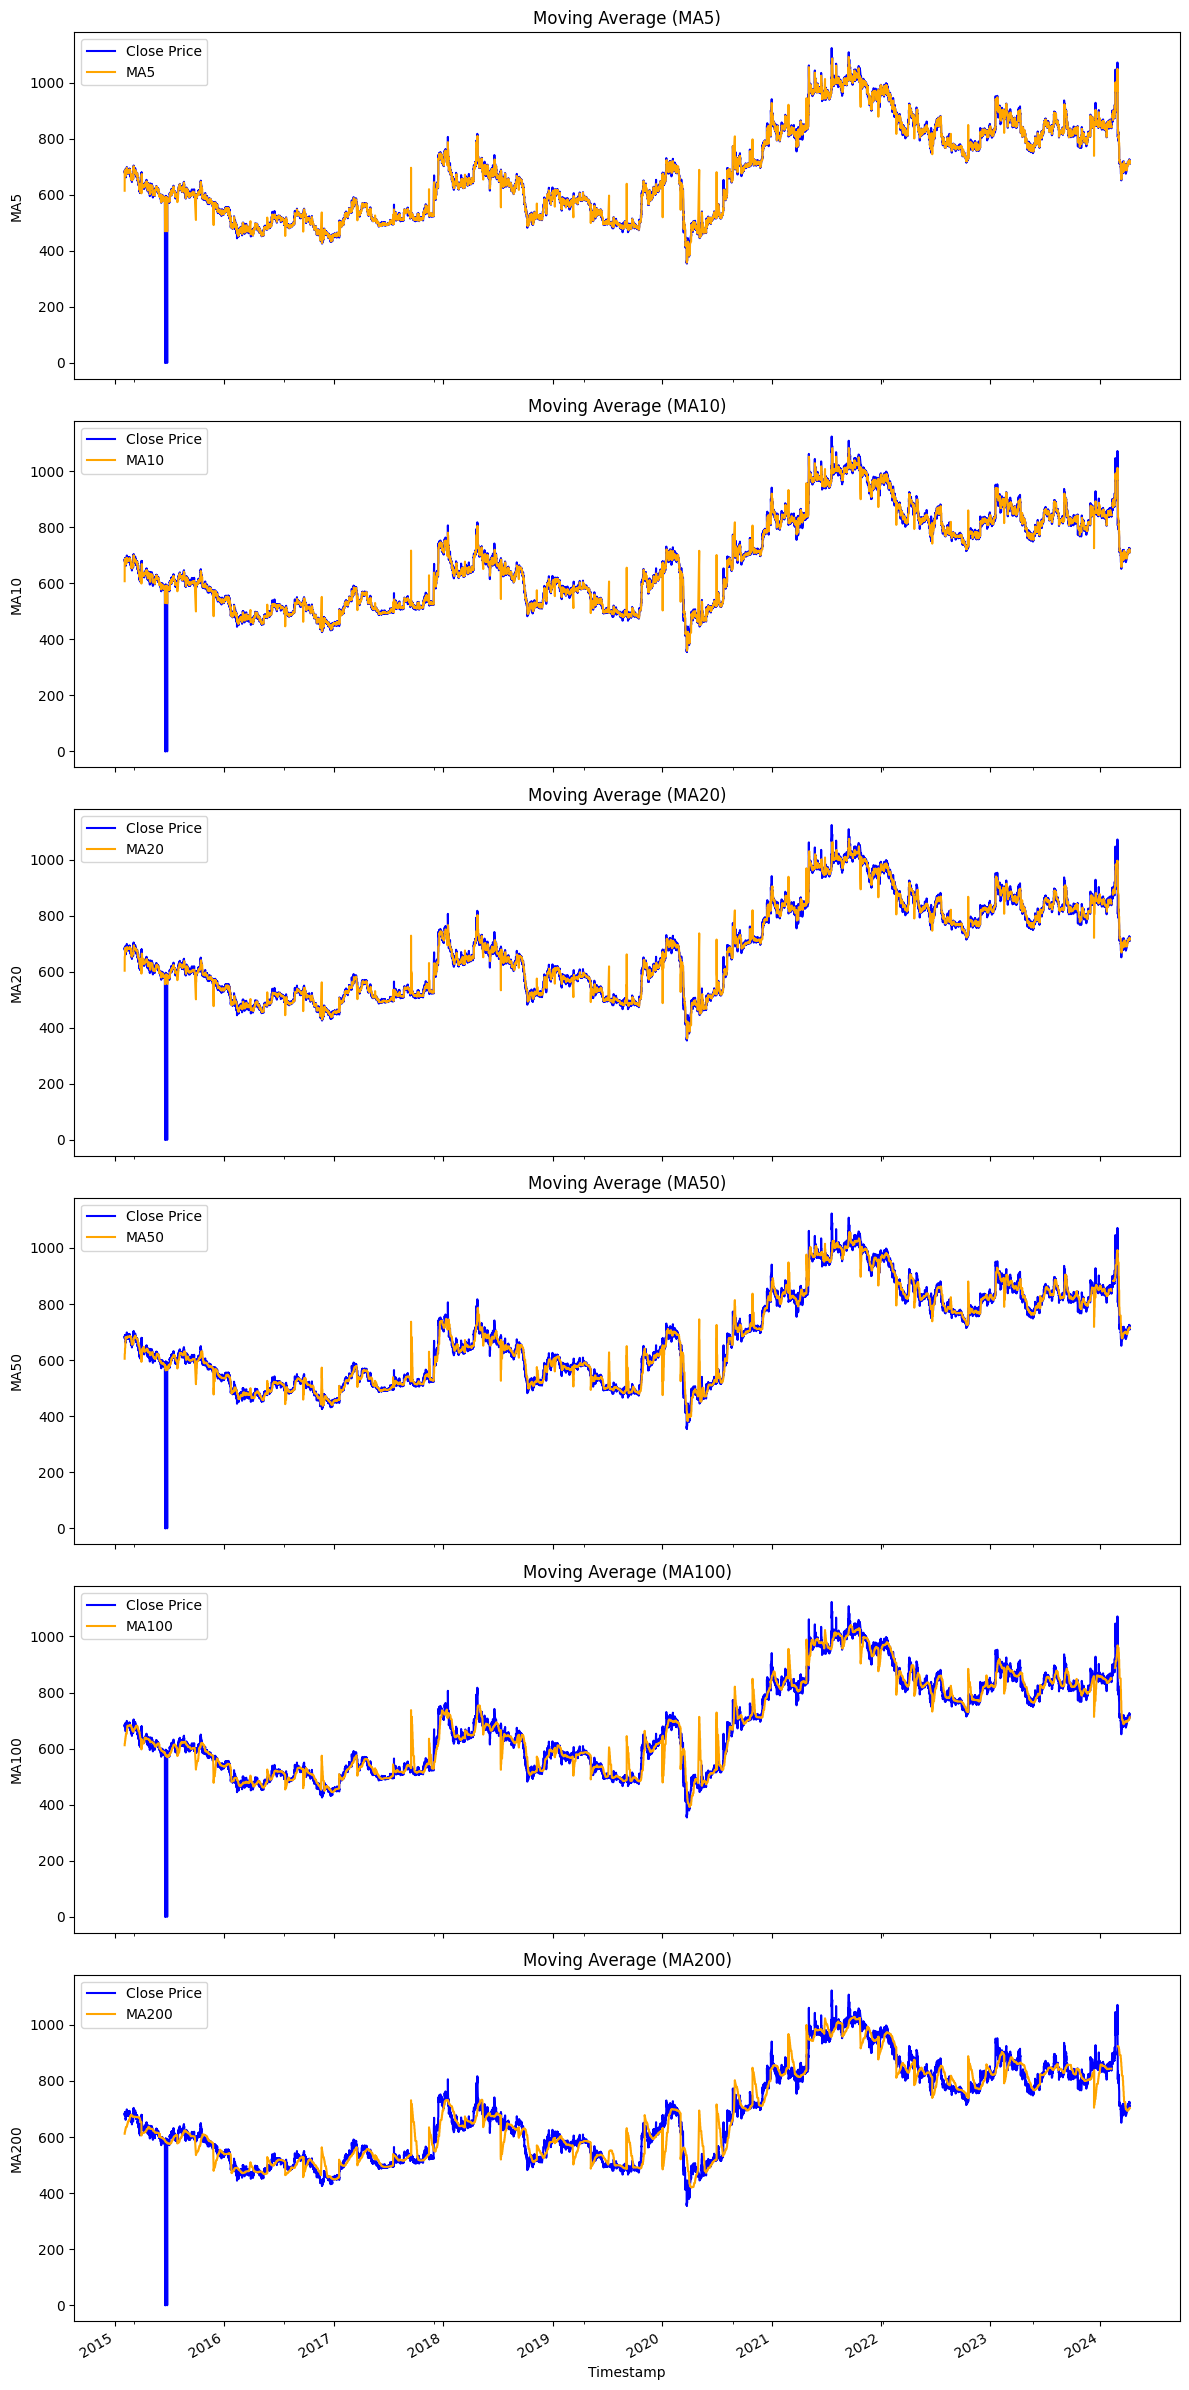

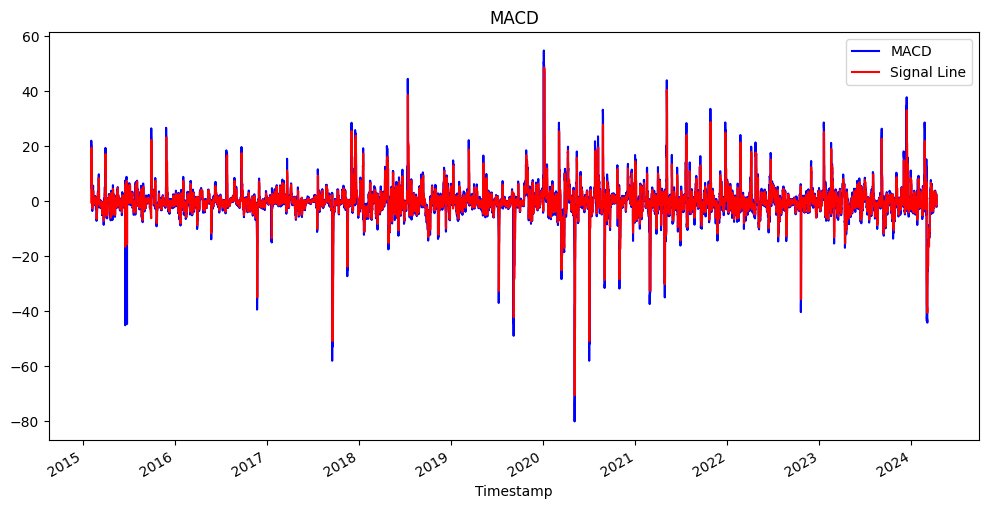

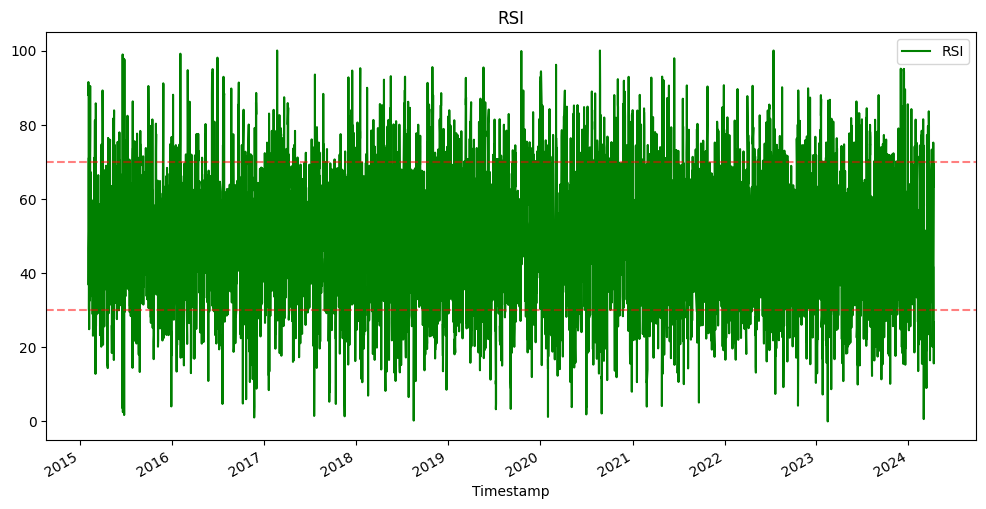

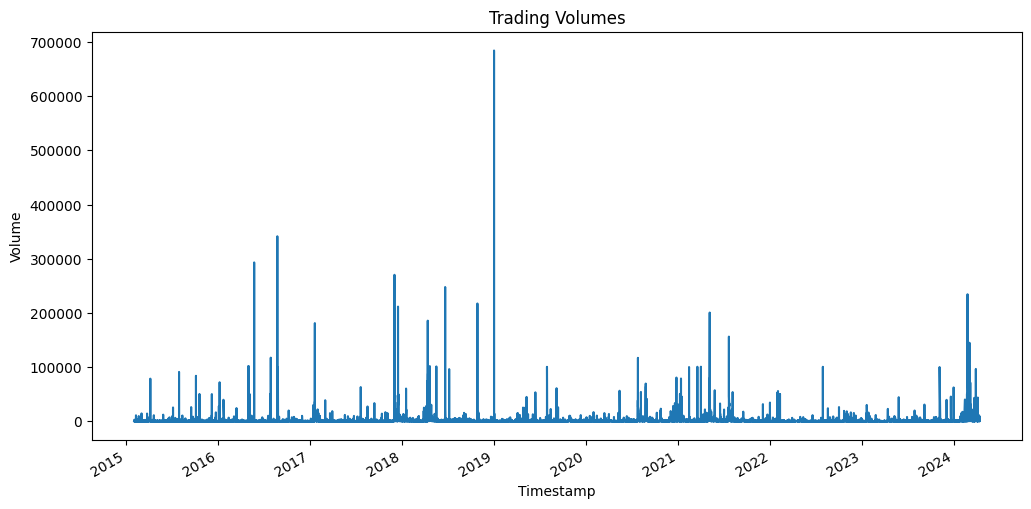

                                                   Date    Open   Close  \
Timestamp                                                                 
2024-02-12 09:15:00+05:30   Monday-12-Feb-2024 09:15:00  846.55  900.00   
2024-02-12 09:45:00+05:30   Monday-12-Feb-2024 09:45:00  900.00  876.55   
2024-02-12 10:15:00+05:30   Monday-12-Feb-2024 10:15:00  877.30  885.00   
2024-02-12 10:45:00+05:30   Monday-12-Feb-2024 10:45:00  885.00  890.60   
2024-02-12 11:15:00+05:30   Monday-12-Feb-2024 11:15:00  890.60  885.60   

                              Low   High   Volume     MA5  MA10  MA20  MA50  \
Timestamp                                                                     
2024-02-12 09:15:00+05:30  843.55  925.0  40422.0     NaN   NaN   NaN   NaN   
2024-02-12 09:45:00+05:30  876.00  900.0  21381.0     NaN   NaN   NaN   NaN   
2024-02-12 10:15:00+05:30  872.00  890.1  11271.0     NaN   NaN   NaN   NaN   
2024-02-12 10:45:00+05:30  876.00  890.6   3880.0     NaN   NaN   NaN   NaN   


In [35]:
def main():
    stock_name = 'AGRO_TECH_FOODS'
    file_path = '/content/' + stock_name + '.csv'
    data = load_data(file_path)
    resampled_data = resample_data(data)
    plot_resampled_data(resampled_data)

    ma_windows = [5, 10, 20, 50, 100, 200]
    data_with_values = add_computed_values(data, ma_windows)

    # Plot the indicators
    plot_moving_averages(data_with_values, ma_windows)
    plot_macd(data_with_values['MACD'], data_with_values['Signal'])
    plot_rsi(data_with_values['RSI'])
    plot_volume(data_with_values)

    # Now data_with_values contains all the computed values and can be visualized or stored
    print(data_with_values.head())  # Display the first few rows to verify the added columns

    all_strategies_data = data_with_values.copy()

    # Apply strategies and backtest
    print("Backtesting Moving Average Strategies with Close Price...")
    lookback_period = 1  # Define the lookback period
    for window in ma_windows:
        data_with_strategy = moving_average_signal(data_with_values.copy(), window, lookback_period)
        data_with_strategy, total_gain = backtest_strategy(
            data_with_strategy, f'Position_MA{window}', f'Portfolio_MA{window}'
        )
        print(f'Total gain from Close Price and MA{window} strategy: ${total_gain:.2f}')
        all_strategies_data = all_strategies_data.join(data_with_strategy[[f'Signal_MA{window}', f'Position_MA{window}', f'Portfolio_MA{window}']])

    print("Backtesting RSI Strategy...")
    data_with_strategy = rsi_strategy(data_with_values.copy(), 30, 70)
    data_with_strategy, total_gain_rsi = backtest_strategy(data_with_strategy, 'Position_RSI', 'Portfolio_RSI')
    print(f'Total gain from RSI strategy: ${total_gain_rsi:.2f}')
    all_strategies_data = all_strategies_data.join(data_with_strategy[['Signal_RSI', 'Position_RSI', 'Portfolio_RSI']])

    print(all_strategies_data.head())  # Display the updated dataframe with signals and portfolio values

    # Save the final DataFrame to a new CSV file
    output_file_path = '/content/' + stock_name + '_with_strategies.csv'
    all_strategies_data.to_csv(output_file_path, index=False)
    print(f"Data with strategies saved to {output_file_path}")

    upload_data_to_firebase(all_strategies_data, stock_name)

if __name__ == "__main__":
    main()
